# Achtergrond

Tijdens het maken van deze opdracht kon ik niet bij de code in GitHub Classroom. Ik had hier al eerder problemen mee. Mogelijk is dat omdat ik de opdrachten probeer te maken buiten de reguliere periode. Eerder had ik ook problemen met dat GitHub mijn school account niet wilde linken maar dat lijkt nu wel gebeurt te zijn. 

Omdat ik de code van de opdracht niet kon gebruiken moest ik andere code vinden/schrijven. Hoewel ik online versies kon vinden die de set visualiseerde waren deze vaak al geoptimaliseerd. Dit zou het nut van de opdracht te niet doen. Uiteindelijk heb ik een versie gevonden die de plot visualiseert in de command line. Deze heb ik herschreven en geparresliseert. 

# Ontwerp

De orginelen code vereist input van de gebruiker voor welke mutatie moet plaatsvinden. Daarvoor genereer ik een set van random inputs om zo een set aan mutaties te krijgen. In het algemeen werkt de code als volgt:

voor een bepaalde range gebaseerd op de grote van de window
voor elke pixel
    bereken of deze in de julia set zit
    assing het een kleur
    plot de kleur

omdat dit voor elke pixel individueel moet worden berekent kan dit worden geparreliseerd. Met OMP word het berekenen van of een pixel in de julia set zit en het assingen van een kleur gepareliseerd. Welke kleur welke pixel moet zijn wordt opgeslagen in memory en als dit voor elke pixel is gedaan plot de mainthreat de frame.





# Results

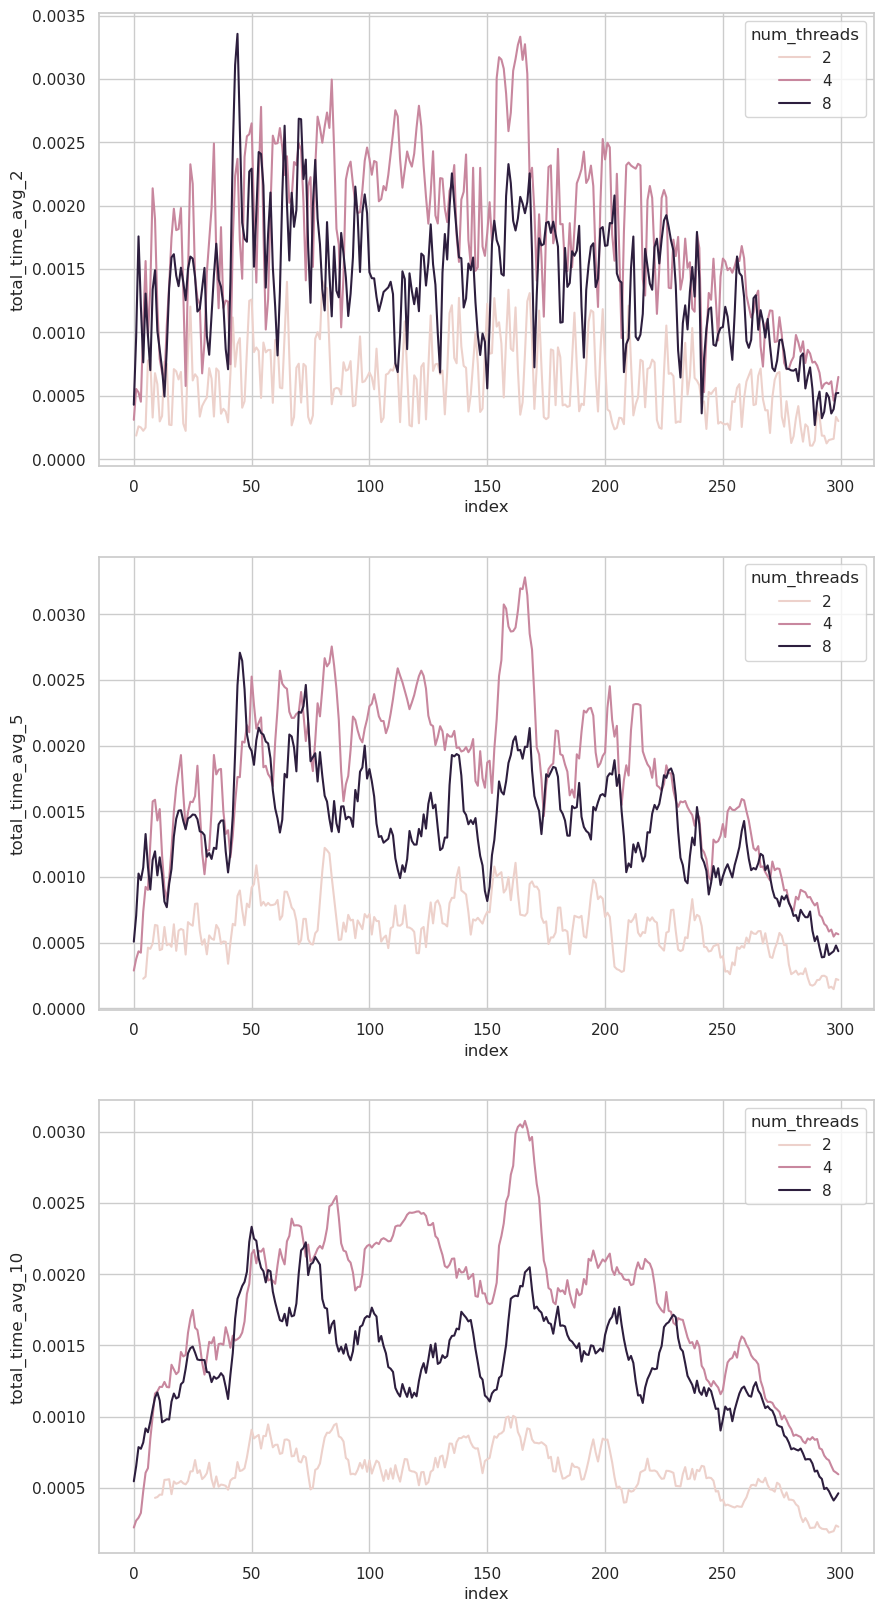

In [ ]:
import pandas as pd

columns = ["num_procces", "num_threads", "id", "mutation_code", "total_time"]
df_1 = pd.read_csv("results/fractal/results_1P_2t.csv", names=columns, index_col=False)
df_2 = pd.read_csv("results/fractal/results_1P_4t.csv", names=columns, index_col=False)
df_3 = pd.read_csv("results/fractal/results_1P_8t.csv", names=columns, index_col=False)

df = pd.concat([df_1, df_2, df_3])
df = df.reset_index(drop=False)


# plot index vs total_time
import matplotlib.pyplot as plt
import seaborn as sns

# plot index vs total_time with a moving average of 10 
import numpy as np
df["total_time_avg_2"] = df["total_time"].rolling(window=2).mean()
df["total_time_avg_5"] = df["total_time"].rolling(window=5).mean()
df["total_time_avg_10"] = df["total_time"].rolling(window=10).mean()

# Creates 3 subplots for eacht moving average
fig, axs = plt.subplots(3, figsize=(10, 20))
sns.lineplot(data=df, x="index", y="total_time_avg_2", hue="num_threads", ax=axs[0])
sns.lineplot(data=df, x="index", y="total_time_avg_5",  hue="num_threads", ax=axs[1])
sns.lineplot(data=df, x="index", y="total_time_avg_10",  hue="num_threads", ax=axs[2])
plt.show()


# Tekortkomingen

Voor elke frame worden nu threads aangemaakt en vernietigd. Dit kan voor relatief veel overhead zorgen. In de grafiek is ook te zien dat 4 threads het slechtst scoort. 8 threads scoort net iets beter. Dit is apart, want als het aanmaken van threads voor vertraging zorgt, dan zou 8 threads lager moeten scoren dan 4 threads. En als er winst zit in de optimalisatie, dan zou 2 threads niet het best moeten scoren.

De computatietijd verschilt erg per mutatie. Het kan dat tijdens het testen van de 4 threads er een relatief ingewikkelde set met mutaties is gegenereerd. In de grafiek is ook te zien dat de dalen redelijk overeenkomen met die van 8 threads. Echter, wanneer de pieken en dalen plaatsvinden, komen deze wel redelijk overeen. De grafiek en uitgevoerde test zijn dus niet erg inzichtelijk. 

Wat de grafiek laat zien, is dat de computatietijd erg afhankelijk is van welke mutatie heeft plaatsgevonden en dat dit erg varieert per frame. Een andere optie is om het genereren van de frames als geheel te paralleliseren. In de huidige implementatie kan dit schelen omdat er dan niet per frame threads moeten worden verdeeld. Echter moet de code dan wel aanzienlijk worden herschreven zodat als een pixel is berekent het naar een tijdelijk adress wordt geschreven met een reference voor welke frame dit de pixel is. Anders dan is de kans groot dat een tweede thread een pixel al een andere waarden heeft gegeven voordat deze is gevisualiseerd naar de gebruiker.

Het is sowieso beter om een implementatie te maken die gebruik maakt van de GPU. De code zal dan het zelfde werken maar het zou worden uitgevoerd door de gpu. Dit zou kunnen met CUDA. Echter is dit mij niet gelukt en lijkt het schrijven van een volledige cuda implementatie mij ook buiten de scope van de opdracht. 

# Code

In [ ]:
#include <ncurses.h>
#include <cmath>
#include <stdlib.h>
#include <math.h>
#include <mpi.h>
#include <iostream>
#include <omp.h> // OpenMP
#include <chrono> // std::chrono::microseconds
#include <thread> // std::this_thread::sleep_for


using namespace std;

#define NUM_POINTS 10000
#define SCALE_FACTOR 0.1
#define ITER 42
#define NUM_THREADS 8
#define RESULTS_FILE "results_1P_4t.txt"


// Because I was unable to acces the github classroom I was unable use the provided framework. 
// I found my own function to render the julia set.  Source: https://github.com/mdabir1203/CursedFractals/tree/master
// This is my edited variant

float x_pos = 0, y_pos = 0;
float zoom = 1;
bool use_julia = true;

void stemTransformation(double *x, double *y)
{
    *y += 0.05;
}

void leftLeafTransformation(double *x, double *y)
{
    double new_x = 0.85 * (*x) - 1.6;
    *y += 0.04;
    *x = new_x;
}

void rightLeafTransformation(double *x, double *y)
{
    double new_x = 0.2 * (*x) + 0.23;
    *y -= 0.26;
    *x = new_x;
}

void centerLeafTransformation(double *x, double *y)
{
    double new_x = -0.15 * (*x) + 0.26;
    *y += 0.28;
    *x = new_x;
}

// Function to calculate whether a point belongs to the Julia set
int julia(double x, double y) {
    double z_real = x, z_imag = y;
    double c_real = -0.7, c_imag = 0.27015; // Constants for the Julia set
    int iteration = 0;
    
    while (z_real * z_real + z_imag * z_imag <= 4 && iteration < ITER) {
        double temp = z_real * z_real - z_imag * z_imag + c_real;
        z_imag = 2 * z_real * z_imag + c_imag;
        z_real = temp;
        iteration++;
    }
    
    return iteration == ITER ? 0 : iteration;
}

void color_pixel(int i, int x, int y){
    for (int j = 0; j < y; j++) {
        // Calculate the coordinates of the point based on x_pos, y_pos, and zoom which are global variables
        double x_coord = (((double)i - (double)x / 2.) * (4. / (double)x)) * zoom + x_pos;
        double y_coord = y_pos + zoom * ((double)j - (double)y / 2.) * (4. / (double)y * ((2.5 * 9.) / 16.));

        int result;
        if (use_julia)
            result = julia(x_coord, y_coord);

        switch (result % 7) {
            case 0:
                attron(COLOR_PAIR(1));
                break;
            case 1:
                attron(COLOR_PAIR(2));
                break;
            case 2:
                attron(COLOR_PAIR(3));
                break;
            case 3:
                attron(COLOR_PAIR(4));
                break;
            case 4:
                attron(COLOR_PAIR(5));
                break;
            case 5:
                attron(COLOR_PAIR(6));
                break;
            default:
                attron(COLOR_PAIR(7));
                break;
        }
        
        // Display character
        if (result == 0)
            mvprintw(j, i, "#");
        else
            mvprintw(j, i, " ");

        // Turn off color pairs
        attroff(COLOR_PAIR(1));
        attroff(COLOR_PAIR(2));
        attroff(COLOR_PAIR(3));
        attroff(COLOR_PAIR(4));
        attroff(COLOR_PAIR(5));
        attroff(COLOR_PAIR(6));
        attroff(COLOR_PAIR(7));
    }
}

// Function to draw the Julia set on the terminal window
void draw() {
    int x, y;
    getmaxyx(stdscr, y, x);
    omp_set_num_threads(NUM_THREADS);
    for (int i = 0; i < x; i+=NUM_THREADS) {
        color_pixel(i, x, y);
    }

    refresh();
}


int main(int argc, char *argv[]) {
    int id = -1, numProcesses = -1;
    double startTime = 0.0, totalTime = 0.0;
    initscr();
    raw();
    keypad(stdscr, TRUE);
    noecho();
    curs_set(0);
    start_color();
    
    // Initializing color pairs
    init_pair(1, COLOR_WHITE, COLOR_BLACK);   // Inside Julia set
    init_pair(2, COLOR_BLACK, COLOR_BLUE);    // Deep blue
    init_pair(3, COLOR_BLACK, COLOR_CYAN);    // Cyan
    init_pair(4, COLOR_BLACK, COLOR_GREEN);   // Green
    init_pair(5, COLOR_BLACK, COLOR_YELLOW);  // Yellow
    init_pair(6, COLOR_BLACK, COLOR_RED);     // Red
    init_pair(7, COLOR_BLACK, COLOR_MAGENTA); // Magenta
    MPI_Init(&argc, &argv);
    MPI_Comm_rank(MPI_COMM_WORLD, &id);
	MPI_Comm_size(MPI_COMM_WORLD, &numProcesses);
    
    draw(); // Initial drawing
    
    for (int i = 0; i < 300; i++){
        int randomNum = rand() % 5;
        switch (randomNum){
            case 0:
                // Zooms in 
                y_pos -= 0.15 * zoom;
                break;
            case 1:
                // Zooms out
                y_pos += 0.15 * zoom;
                break;
            case 2:
                // Moves left
                x_pos -= 0.15 * zoom;
                break;
            case 3:
                // Moves right
                x_pos += 0.15 * zoom;
                break;
            case 4:
                // Zooms in
                zoom *= 0.9;
                break;
        }
        
        startTime = MPI_Wtime();
        draw();
        totalTime = MPI_Wtime() - startTime;
        // write the procces id, time taken and if it is the main thread to results.txt
        FILE *file = fopen("results.txt", "a");
        fprintf(file, "%d, %d, %d, %d, %f,\n", numProcesses, NUM_THREADS, id, randomNum, totalTime);
        fclose(file);
        std::this_thread::sleep_for(std::chrono::microseconds{50000});

    }
    endwin();
    MPI_Finalize();
    return 0;
}
